In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/covid19-tweets/covid19_tweets.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv


In [2]:
df_train = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding = 'latin1')
df_test = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv', encoding = 'latin1')

In [3]:
df_train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


Text(0.5, 1.0, 'Distribution of sentiment in training data')

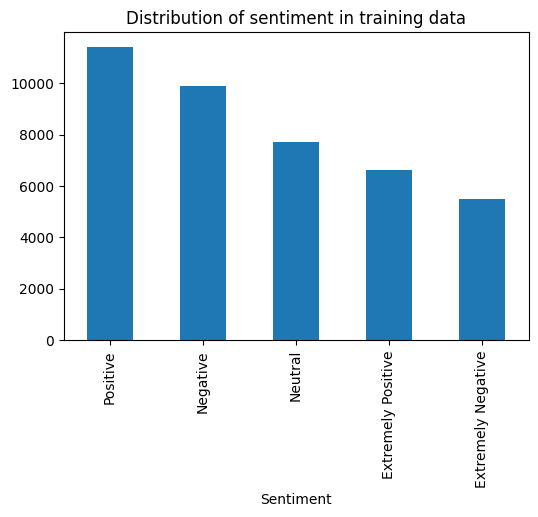

In [4]:
plt.figure(figsize = (6,4))
df_train.Sentiment.value_counts().plot(kind = 'bar')
plt.title('Distribution of sentiment in training data')

Text(0.5, 1.0, 'Distribution of sentiment in test data')

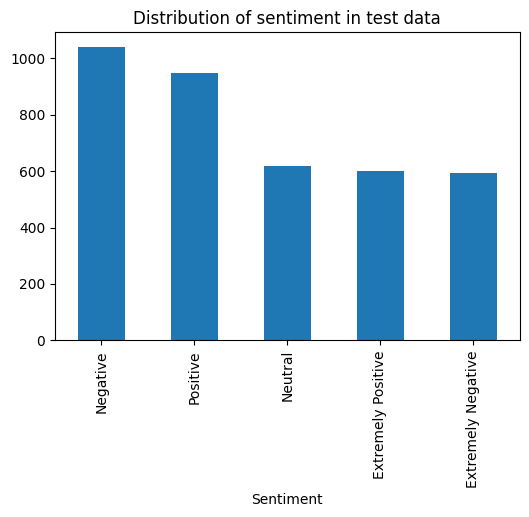

In [5]:
plt.figure(figsize = (6,4))
df_test.Sentiment.value_counts().plot(kind = 'bar')
plt.title('Distribution of sentiment in test data')

In [6]:
x = df_train['OriginalTweet']
y = df_train['Sentiment']

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow.keras.layers as layer
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [8]:
import nltk
from nltk.corpus import stopwords

In [9]:
#Cleaning the texts and getting rid of unclear symbols or characters
#This function is from: https://www.kaggle.com/code/shahraizanwar/covid19-tweets-sentiment-prediction-rnn-85-acc
import re
def text_cleaner(tweet):
    
    # remove urls
    tweet = re.sub(r'http\S+', ' ', tweet)
    
    # remove html tags
    tweet = re.sub(r'<.*?>',' ', tweet)
    
    # remove digits
    tweet = re.sub(r'\d+',' ', tweet)
    
    # remove hashtags
    tweet = re.sub(r'#\w+',' ', tweet)
    
    # remove mentions
    tweet = re.sub(r'@\w+',' ', tweet)
    
    #removing stop words
    tweet = tweet.split()
    tweet = " ".join([word for word in tweet if not word in stop_words])
    
    return tweet


stop_words = stopwords.words('english')

X_c = x.apply(text_cleaner)
X_c.head()

0                                                     
1    advice Talk neighbours family exchange phone n...
2    Coronavirus Australia: Woolworths give elderly...
3    My food stock one empty... PLEASE, panic, THER...
4    Me, ready go supermarket outbreak. Not I'm par...
Name: OriginalTweet, dtype: object

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_c)

X = tokenizer.texts_to_sequences(X_c)

In [11]:
vocab_size = len(tokenizer.word_index)+1

print("Vocabulary size: {}".format(vocab_size))
print("\nExample:\n")
print("Sentence:\n{}".format(X_c[8]))
print("\nAfter tokenizing :\n{}".format(X[8]))

X = pad_sequences(X, padding='post')
print("\nAfter padding :\n{}".format(X[8]))

Vocabulary size: 36117

Example:

Sentence:
Due COVID- retail store classroom Atlanta open walk-in business classes next two weeks, beginning Monday, March . We continue process online phone orders normal! Thank understanding!

After tokenizing :
[34, 1, 69, 4, 11239, 4874, 153, 665, 39, 104, 2637, 174, 172, 146, 812, 766, 186, 25, 267, 1487, 13, 802, 450, 326, 102, 2185]

After padding :
[   34     1    69     4 11239  4874   153   665    39   104  2637   174
   172   146   812   766   186    25   267  1487    13   802   450   326
   102  2185     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]


In [12]:
sentiments = {'Extremely Negative': 0,
            'Negative': 0,
            'Neutral': 1,
            'Positive':2,
            'Extremely Positive': 2
           }
y = y.map(sentiments)
labels = ['Negative', 'Neutral', 'Positive']

In [13]:
X_test = df_test['OriginalTweet'].copy()
y_test = df_test['Sentiment'].copy()

X_test = X_test.apply(text_cleaner)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, padding='post', maxlen = X.shape[1])

y_test = y_test.map(sentiments)

# Generic model

In this section, we will write a function to define a general model that takes in as the first input the type of recurrent layer (RNN, LSTM, GRU, etc.), the second input is the number of units in the recurrent layer, and the last two inputs are the number of training epochs and batch size. This function will output the trained model, the loss and accuracy of the model evaluated on the test set, and the confusion matrix.

In [14]:
def generic_model(model_layer,units, epochs, bs):
    EPOCHS = epochs
    BATCH_SIZE = bs
    embedding_dim = 16

    model= tf.keras.Sequential([
        layer.Embedding(vocab_size, embedding_dim, input_length=X.shape[1]),
        model_layer(units),
        layer.Dense(3,activation = 'softmax')
    ])
    
    model.summary()

    model.compile(loss=SparseCategoricalCrossentropy(from_logits = False),
              optimizer='adam',metrics=['accuracy']
             )
    
    history = model.fit(X, y, epochs=EPOCHS, 
                                  validation_split=0.15, batch_size=BATCH_SIZE)
    hist_model = pd.DataFrame(history.history)
    
    #Plot the loss and accuracy curves
    fig, ax = plt.subplots(2,1, figsize = (8,8))
    ax[0].plot(hist_model.loss, c = 'b')
    ax[0].plot(hist_model.val_loss, c = 'r')
    ax[0].set_title('Training and validation losses');
    ax[0].set_ylabel('Loss')
    ax[0].legend(['train', 'val'], loc='upper left')

    ax[1].plot(hist_model.accuracy, c = 'b')
    ax[1].plot(hist_model.val_accuracy, c = 'r')
    ax[1].set_title('Training and validation accuracies');
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['train', 'val'], loc='upper left')
    
    #Prediction
    pred = np.argmax(np.round(model.predict(X_test)),axis = 1)
    loss, acc = model.evaluate(X_test,y_test,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
    
                 
    #Confustion matrix
    confm = confusion_matrix(y_test, pred)
    cm= pd.DataFrame(confm, index = [i for i in labels],
                    columns = [i for i in labels])

    plt.figure(figsize = (8,6))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion Matrix')
    plt.show()
                
    return model, hist_model, loss, acc, cm

# RNN Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 54, 16)            577872    
                                                                 
 simple_rnn (SimpleRNN)      (None, 20)                740       
                                                                 
 dense (Dense)               (None, 3)                 63        
                                                                 
Total params: 578,675
Trainable params: 578,675
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
1094/1094 [==============================] - 86s 75ms/step - loss: 1.0408 - accuracy: 0.4346 - val_loss: 1.0762 - val_accuracy: 0.3614
Epoch 2/8
1094/1094 [==============================] - 54s 50ms/step - loss: 1.0035 - accuracy: 0.4881 - val_loss: 1.0053 - val_accuracy: 0.4755
Epoch 3/8
1094/1094 [===

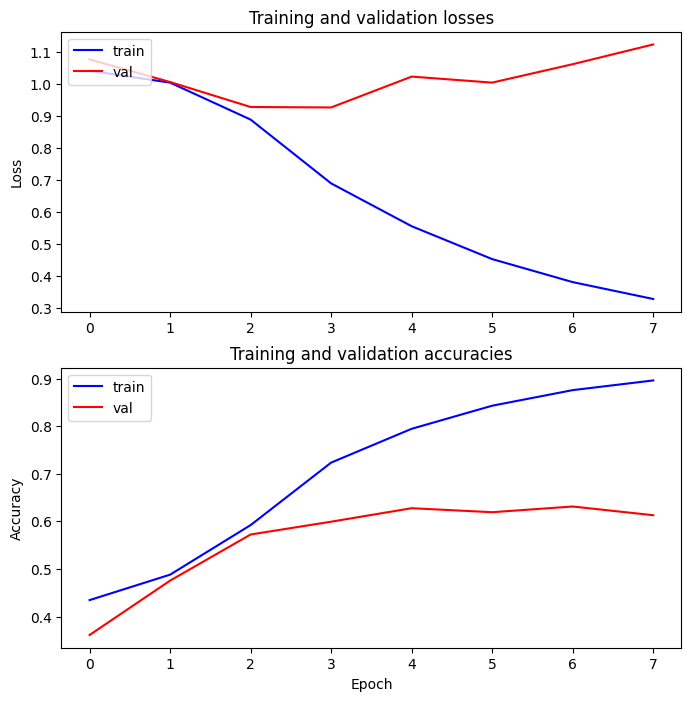

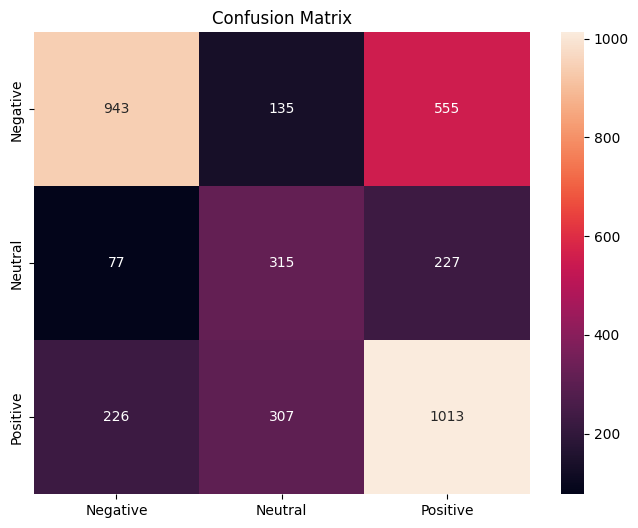

In [15]:
model_RNN = generic_model(layer.SimpleRNN, 20, 8, 32)

# LSTM Model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 54, 16)            577872    
                                                                 
 lstm (LSTM)                 (None, 15)                1920      
                                                                 
 dense_1 (Dense)             (None, 3)                 48        
                                                                 
Total params: 579,840
Trainable params: 579,840
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
1094/1094 [==============================] - 31s 26ms/step - loss: 0.9332 - accuracy: 0.4962 - val_loss: 0.8205 - val_accuracy: 0.6003
Epoch 2/6
1094/1094 [==============================] - 9s 8ms/step - loss: 0.5955 - accuracy: 0.7726 - val_loss: 0.5251 - val_accuracy: 0.8139
Epoch 3/6
1094/1094 [===

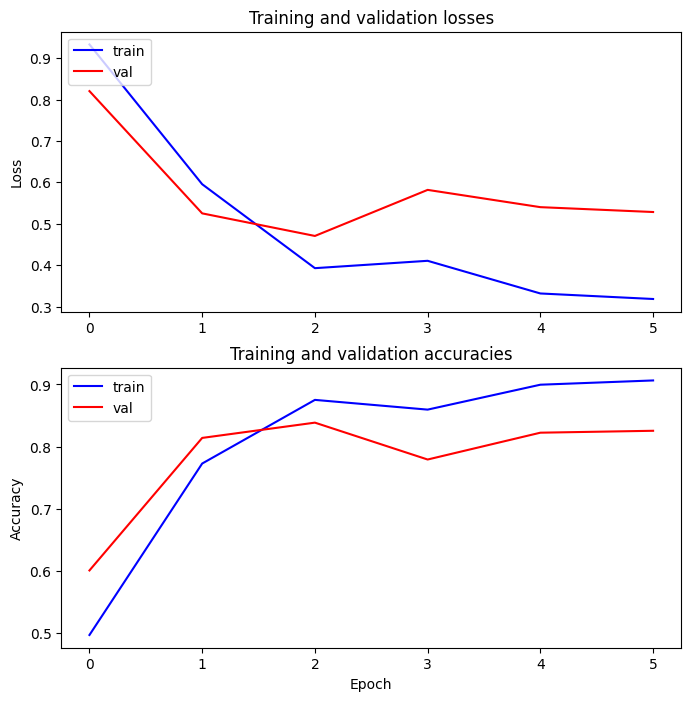

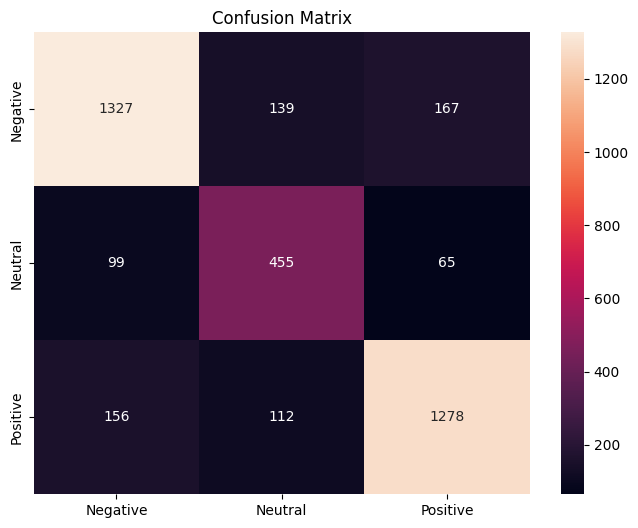

In [16]:
model_LSTM = generic_model(layer.LSTM,15, 6, 32)

# GRU Model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 54, 16)            577872    
                                                                 
 gru (GRU)                   (None, 15)                1485      
                                                                 
 dense_2 (Dense)             (None, 3)                 48        
                                                                 
Total params: 579,405
Trainable params: 579,405
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
1094/1094 [==============================] - 30s 26ms/step - loss: 1.0442 - accuracy: 0.4337 - val_loss: 1.0483 - val_accuracy: 0.4606
Epoch 2/6
1094/1094 [==============================] - 8s 8ms/step - loss: 1.0425 - accuracy: 0.4346 - val_loss: 1.0499 - val_accuracy: 0.4606
Epoch 3/6
1094/1094 [===

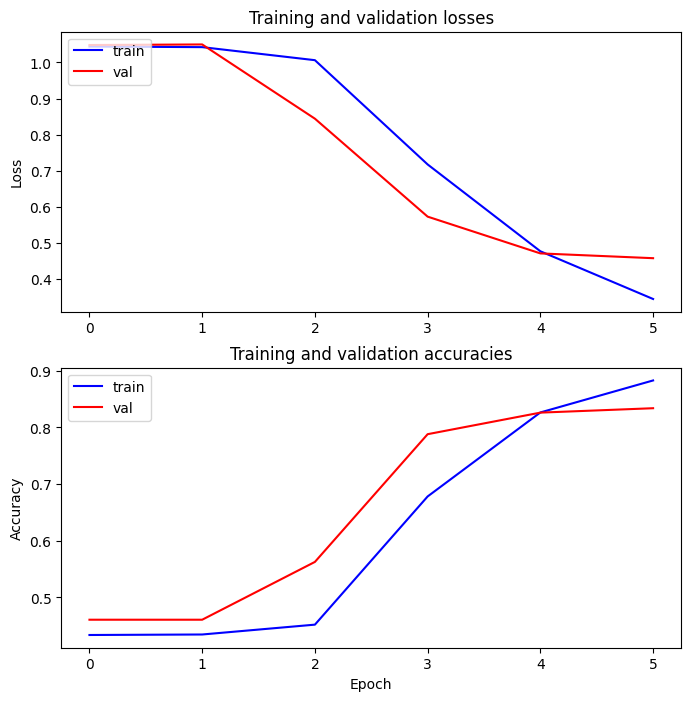

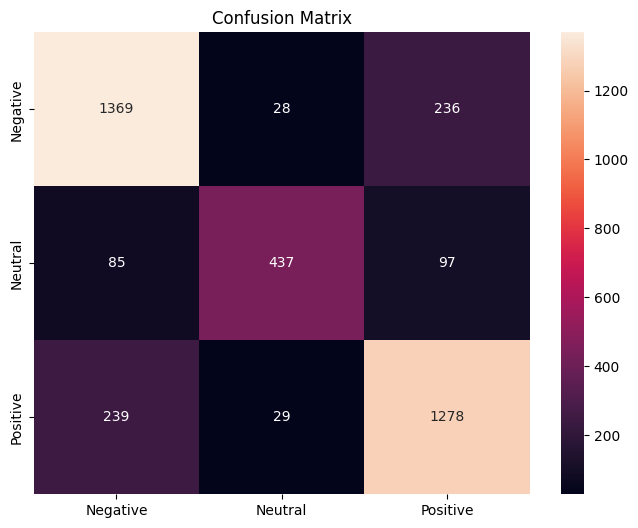

In [17]:
model_GRU = generic_model(layer.GRU,15, 6, 32)